### Generating and Plotting 2D Swiss roll in 3D

In [10]:
from src.generate_data import generate_dataset
from src.make_plots import plot_swiss_roll_3d

# Step 1: Generate swiss roll
data = generate_dataset(
    name="swiss_roll",
    n_samples=5000,
    embed_dim=3,        # We want 2D swiss roll in 3D
    noise_sigma=0.1,
    random_state=42,
)

X = data["X"]   # (5000, 3)
u = data["u"]   # (5000,) parameter, nice for coloring

# Step 2: Plot swiss roll
fig = plot_swiss_roll_3d(X, color=u, title="Swiss Roll (colored by u)")
fig.show()


### Generating and Plotting 2D Swiss Roll in 10D

In [11]:
data = generate_dataset(
    name="swiss_roll",
    n_samples=5000,
    embed_dim=10, # Embed in 10D
    random_state=0,
)

X_10 = data["X"]
X_3 = X_10[:, :3]  # quick projection for plotting
fig = plot_swiss_roll_3d(X_3, color=data["u"])
fig.show()


In [12]:
from src.generate_data import generate_dataset
from src.manifold_learning import estimate_tangent_normal_knn_pca
from src.make_plots import plot_swiss_with_local_frames_3d

# 1. Generate swiss roll in 3D
data = generate_dataset(
    name="swiss_roll",
    n_samples=2000,
    embed_dim=3,
    noise_sigma=0.0,
    random_state=0,
)

X = data["X"]  # (N, 3)

# 2. Estimate local tangent/normal frames via KNN + PCA
frames = estimate_tangent_normal_knn_pca(
    X,
    intrinsic_dim=2,   # swiss roll is 2D
    n_neighbors=32,
    include_self=True,
)

# 3. Plot swiss roll with tangent planes and normals
fig = plot_swiss_with_local_frames_3d(
    frames,
    every_n=100,           # draw a frame every 50 points
    plane_scale=2,
    normal_scale=2,
    title="Learned tangent planes + normals",
)
fig.show()


In [13]:
from src.generate_data import generate_dataset
from src.manifold_learning import estimate_tangent_normal_knn_pca
from src.diffusion import DiffusionExperiment

# 1. Data
data = generate_dataset(
    name="swiss_roll",
    n_samples=5000,
    embed_dim=3,
    noise_sigma=0.0,
    random_state=0,
)
X = data["X"]

# 2. Manifold frames
frames = estimate_tangent_normal_knn_pca(
    X,
    intrinsic_dim=2,
    n_neighbors=32,
    include_self=True,
)

# 3. Diffusion with manifold-aware noise
exp = DiffusionExperiment(
    X=X,
    local_frames=frames,
    tangent_fraction=1.0,
    normal_fraction=0.0,
    mixed_noise=True,
    num_timesteps=1000,
    batch_size=128,
    lr=1e-3,
)

exp.diffusion_train(num_epochs=5)
samples = exp.sample(num_samples=1000)


Epoch 1: loss = 0.828998
Epoch 2: loss = 0.660089
Epoch 3: loss = 0.554762
Epoch 4: loss = 0.546717
Epoch 5: loss = 0.539683


In [14]:
from src.metrics import chamfer_distance, swiss_roll_manifold_distance
import numpy as np
# samples: (N_gen, D) torch.Tensor from exp.sample()
samples_np = samples.cpu().numpy()

# 1) Unknown-manifold metric: dataset vs samples
cd = chamfer_distance(X_true=X, X_gen=samples_np)
print("Chamfer distance:", cd)

# 2) Known-manifold metric for swiss roll
md = swiss_roll_manifold_distance(
    X_gen=samples_np,
    embed_dim=3,
    u_range=(1.5 * np.pi, 4.5 * np.pi),
    v_range=(0.0, 10.0),
    n_u=200,
    n_v=50,
    E=data["E"],   # from generate_dataset
)
print("Swiss-roll manifold distance:", md)

Chamfer distance: 15.768559455871582
Swiss-roll manifold distance: 13.621312141418457


In [15]:
from src.generate_data import generate_dataset
from src.manifold_learning import estimate_tangent_normal_knn_pca
from src.diffusion import DiffusionExperiment

from src.experiments_swissroll import (
    SwissRollExperimentConfig,
    run_swiss_roll_experiment_grid,
)

# 1. Data
data = generate_dataset(
    name="swiss_roll",
    n_samples=5000,
    embed_dim=3,
    noise_sigma=0.0,
    random_state=0,
)
X = data["X"]      # (N, 3)
E = data["E"]      # (3, 3)

# 2. Manifold frames
frames = estimate_tangent_normal_knn_pca(
    X,
    intrinsic_dim=2,
    n_neighbors=5,
    include_self=True,
)



In [ ]:
ratios = np.linspace(0.0, 4.0, 9)   # 0, 0.5, 1, 1.5, ..., 4

configs = []
for r in ratios:
    name = f"tangent_ratio_{r:.2f}"
    cfg = SwissRollExperimentConfig(
        name=name,
        use_manifold=True,
        mixed_noise=True,
        tangent_fraction=r,
        normal_fraction=1.0
    )
    configs.append(cfg)


In [17]:
results = run_swiss_roll_experiment_grid(
    X=X,
    E=E,
    frames=frames,
    configs=configs,
)



=== Running experiment: tan_only ===
Epoch 1: loss = 0.845238
Epoch 2: loss = 0.663557
Epoch 3: loss = 0.590587
Epoch 4: loss = 0.564193
Epoch 5: loss = 0.554877
Epoch 6: loss = 0.548971
Epoch 7: loss = 0.532142
Epoch 8: loss = 0.535751
Epoch 9: loss = 0.529482
Epoch 10: loss = 0.546042
 -> chamfer=21.2100, swiss_dist=19.7448

=== Running experiment: tan_3_norm_1 ===
Epoch 1: loss = 0.854570
Epoch 2: loss = 0.668115
Epoch 3: loss = 0.591608
Epoch 4: loss = 0.564367
Epoch 5: loss = 0.555727
Epoch 6: loss = 0.551678
Epoch 7: loss = 0.538258
Epoch 8: loss = 0.542063
Epoch 9: loss = 0.535756
Epoch 10: loss = 0.551971
 -> chamfer=19.9525, swiss_dist=18.4662

=== Running experiment: tan_1_norm_1 ===
Epoch 1: loss = 0.888658
Epoch 2: loss = 0.659250
Epoch 3: loss = 0.597477
Epoch 4: loss = 0.573882
Epoch 5: loss = 0.557107
Epoch 6: loss = 0.564227
Epoch 7: loss = 0.566245
Epoch 8: loss = 0.568315
Epoch 9: loss = 0.560102
Epoch 10: loss = 0.573276
 -> chamfer=14.1772, swiss_dist=12.5362


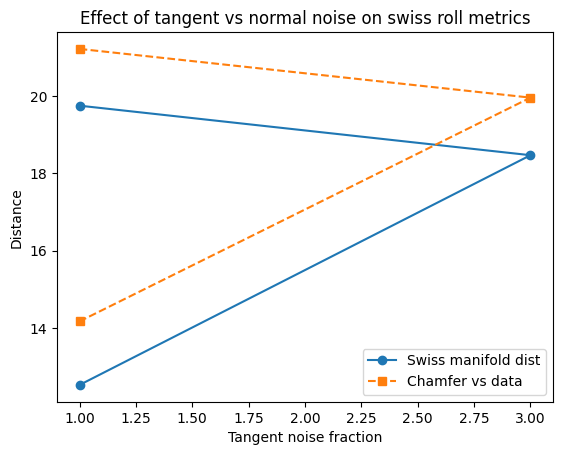

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(results)
df[["name", "use_manifold", "tangent_fraction", "normal_fraction", "chamfer", "swiss_dist"]]

manifold_df = df[df["use_manifold"]]

plt.figure()
plt.plot(
    manifold_df["tangent_fraction"],
    manifold_df["swiss_dist"],
    "o-",
    label="Swiss manifold dist",
)
plt.plot(
    manifold_df["tangent_fraction"],
    manifold_df["chamfer"],
    "s--",
    label="Chamfer vs data",
)
plt.xlabel("Tangent noise fraction")
plt.ylabel("Distance")
plt.legend()
plt.title("Effect of tangent vs normal noise on swiss roll metrics")
plt.show()
